In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np


## let's import some astropy modules
from astropy.io import fits #  to handle FITS files
from astropy.coordinates import SkyCoord # conversion of RA/Dec and other astronomical coordinates
import astropy.units as u # allows you to attach units/dimensions to numbers in a calculation
import astropy.constants as c # stores values and dimensions of major constants
from astropy.wcs import WCS, utils # handling of the world coordinate system information in a FITS header

Astropy has many useful functions for astronomy/astrophysics. Because astropy is open source, there are **many** contributors all over the world, some of whom have dedicated themselves to replacing beloved software (like _iraf_)  that's nearing obsolescense.

We'll start by exploring two of astropy's convenience functions -- _astropy.units_ and _astropy.constants_. These modules allow you to easily convert between units and make sure your results are dimensionally correct. 

# Unit conversions + constants in calculations

Let's solve a quick problem using _astropy.constants_ and _astropy.units_. Say we want to derive the mass of the Galaxy from its circular velocity in the solar neighborhood.

At a radius of 8.5 kpc, the circular velocity of the Milky Way is $v_c \sim 220$ km/s. 

Using the equation $v_c = \sqrt{\frac{GM}{r}}$, solve for the mass of the Galaxy in solar units.

We'll start by defining our given values and attaching units to them:

In [2]:
r = 8.5*u.kpc
v_c = 220*u.km/u.s

M = r * v_c**2/ c.G

M

<Quantity 6.16394229e+15 kg km2 kpc / m3>

You can see that "M" now carries units, but they're kind of strange and some of them should cancel. We can use the function _.decompose()_ to reduce the units.

In [3]:
M.decompose()

<Quantity 1.90199385e+41 kg>

Okay, that's a little better! There are no extraneous units, **but** we want mass in solar masses. Now we can use _.to()_ to convert between kg and $M_\odot$.

In [4]:
M.to(u.Msun)

<Quantity 9.56540138e+10 solMass>

Now let's do a more complicated one -- plot the blackbody curve for a source with a temperature of 6000 K with the correct units. Feel free to do this in either frequency or wavelength space.

In [5]:
def planck_func(nu, T):
    first = 2*c.h*(nu*u.Hz)**3/c.c**2
    second = (np.exp((c.h*nu*u.Hz)/(c.k_B*T*u.K)) - 1)**-1
    
    return (first*second).decompose().to(u.erg/u.s/u.cm**2/u.Hz)
    
def planck_func_wave(lambda_, T):
    first = 2*c.h*c.c**2/(lambda_*u.nm)**5
    second = (np.exp((c.h*c.c)/(lambda_*u.nm*c.k_B*T*u.K)))**-1
    
    return (first*second).decompose().to(u.erg/u.s/u.cm**2/u.nm)

In [6]:
wave = np.linspace(1, 2500, 1000) ## choose some reasonable wavelength and/or frequency ranges
nu = np.logspace(12, 16, 1000)

/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 0, '$\\lambda$ (nm)')

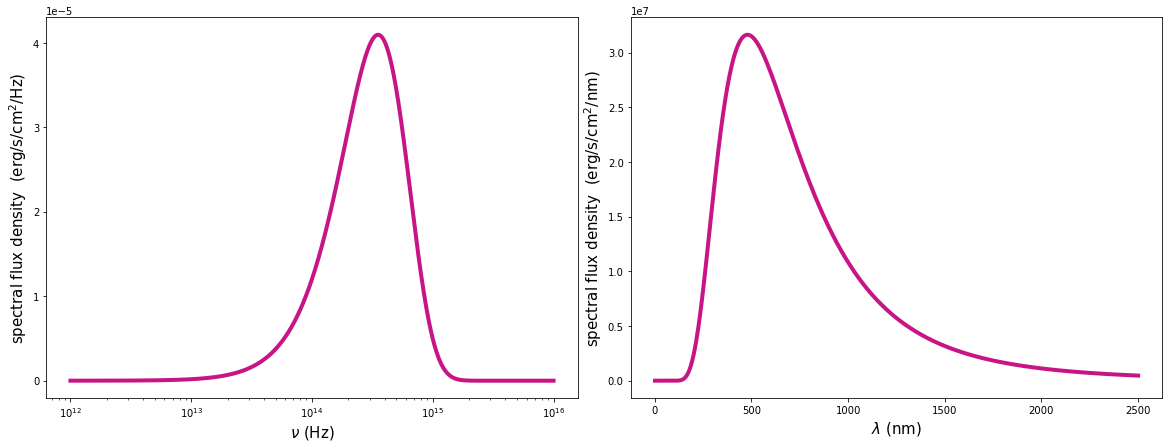

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 7), gridspec_kw={'wspace':0.1})

ax1.plot(nu, planck_func(nu, 6000), color =  'mediumvioletred', lw = 4.)
ax1.set_xscale('log')
ax1.set_ylabel(r'spectral flux density  (erg/s/cm$^2$/Hz)', fontsize = 15)
ax1.set_xlabel(r'$\nu$ (Hz)', fontsize = 15)

ax2.plot(wave, planck_func_wave(wave, 6000), color =  'mediumvioletred', lw = 4.)
ax2.set_ylabel(r'spectral flux density  (erg/s/cm$^2$/nm)', fontsize = 15)
ax2.set_xlabel(r'$\lambda$ (nm)', fontsize = 15)

For many applications including (especially!) dealing with radio astronomy data, using _.constants_ and _.units_ will be big time savers! (That said, it's still useful to understand dimensional analysis and how to convert between units.)

***

# Basic FITS file handling with astropy

While DS9 and MaxIm DL are terrific for viewing, and interacting with, astronomical data through a GUI, often analysis of those data and figure generation are best handled within your own specialized code. Within python, there are multiple ways to read in FITS files, _astropy.io.fits_ is one (lightweight) standard option.

Go ahead and download the two FITS files you'll need for this tutorial [here](https://drive.google.com/drive/folders/1cwc1d-VTUGFbDdQ_ZJ69-GjZl3I4utx0?usp=sharing).

We'll start by actually reading in our data (details of this field [here](https://ui.adsabs.harvard.edu/abs/2021ApJ...914L..23P/abstract)). Assuming that everything is downloaded to the same directory, you can leave the path information as it is. If that's not the case, though, you will need to edit the string that directs the _fits.open()_ to your FITS file.

In [8]:
hdulist = fits.open('jboa61uzq_flc.fits')

hdulist.info()

Filename: jboa61uzq_flc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     281   ()      
  1  SCI           1 ImageHDU       200   (4096, 2048)   float32   
  2  ERR           1 ImageHDU        56   (4096, 2048)   float32   
  3  DQ            1 ImageHDU        48   (4096, 2048)   int16   
  4  SCI           2 ImageHDU       198   (4096, 2048)   float32   
  5  ERR           2 ImageHDU        56   (4096, 2048)   float32   
  6  DQ            2 ImageHDU        48   (4096, 2048)   int16   
  7  D2IMARR       1 ImageHDU        15   (64, 32)   float32   
  8  D2IMARR       2 ImageHDU        15   (64, 32)   float32   
  9  D2IMARR       3 ImageHDU        15   (64, 32)   float32   
 10  D2IMARR       4 ImageHDU        15   (64, 32)   float32   
 11  WCSDVARR      1 ImageHDU        15   (64, 32)   float32   
 12  WCSDVARR      2 ImageHDU        15   (64, 32)   float32   
 13  WCSDVARR      3 ImageHDU        15   (64, 32)   float32   
 14  W

We'll call our generically open FITS file "hdulist" in reference to what is printed with *hdulist.info()*, the list of Header Data Units. (Ultimately, the verbiage matters less than understanding what you've actually read in, so -- as  always -- name your variables in a way that helps **you**.) The different HDUs will have different embedded headers and data. To call one, you can say _hdulist\[{index}\]_ -- let's see what the header information is for the "PRIMARY" HDU. To view the header, simply use the _.header_ command.

Can you identify the telescope, instrument, and filter with which the data was taken? (***Answer: HST, ACS, F814W***)

In [9]:
hdulist[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'HSTIO/CFITSIO March 2010' / FITS file originator                     
DATE    = '2018-10-18' / date this file was written (yyyy-mm-dd)                
NEXTEND =                   15 / Number of standard extensions                  
FILENAME= 'jboa61uzq_flc.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'             

Okay, now that we know something about these data, we should actually view an image. Let's look at the "SCI" HDU. Within matplotlib, we can view array-like data with *plt.imshow*, FITS **data** can be accessed via the _.data_ command. We'll need to define a colormap and dynamic range. The _np.percentile()_ calls in _vmin_ and _vmax_ set that range based on the data itself.

(-0.5, 4095.5, -0.5, 2047.5)

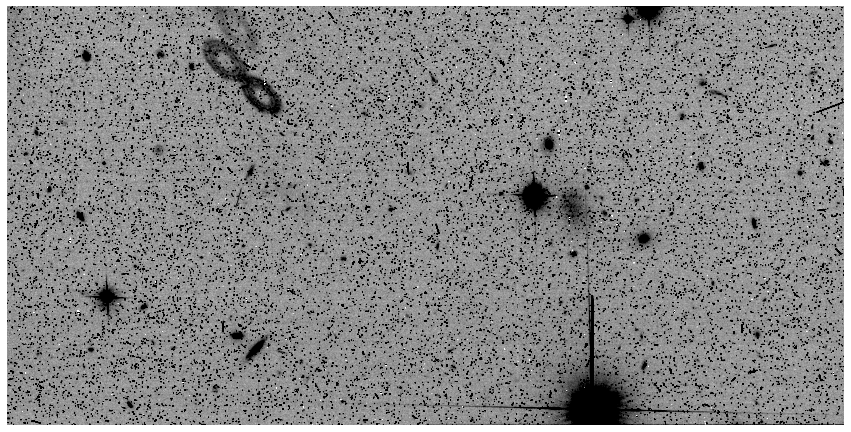

In [10]:
fig = plt.figure(figsize = (15, 10))
plt.imshow(hdulist[1].data, cmap = 'gray_r', vmin = np.percentile(hdulist[1].data, 5), 
           vmax = np.percentile(hdulist[1].data, 95), origin = 'lower')
plt.axis('off')

Now you try -- there's another FITS file in this directory. These data are from the Legacy Survey and cutouts are downloaded not as multi-extension FITS files, but as data cubes. You can use normal array manipulation to access the slice you want. Open it (make sure to check the header!) and show the r-band image. You should carefully select your colormap and 

In [11]:
dat = fits.open('cutout_150.1251_2.1501.fits')

dat.info()

Filename: cutout_150.1251_2.1501.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (256, 256, 3)   float32   


In [12]:
dat[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  256 / length of data axis 1                          
NAXIS2  =                  256 / length of data axis 2                          
NAXIS3  =                    3 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BANDS   = 'grz     '                                                            
BAND0   = 'g       '                                                            
BAND1   = 'r       '                                                            
BAND2   = 'z       '        

In [13]:
dat[0].data.shape

(3, 256, 256)

(-0.5, 255.5, -0.5, 255.5)

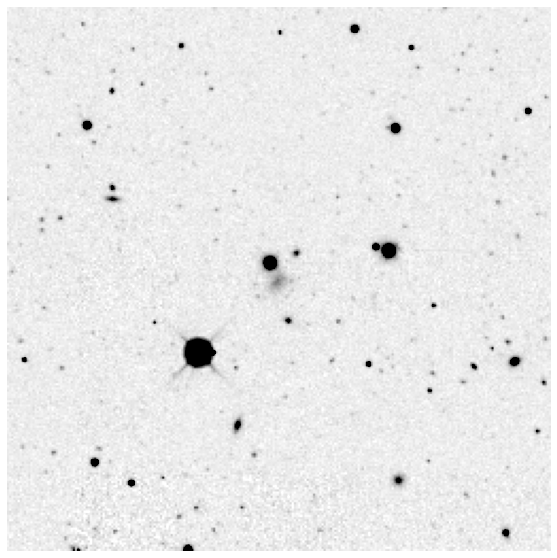

In [14]:
fig = plt.figure(figsize = (10, 10))
plt.imshow(dat[0].data[1, :, :], cmap = 'gray_r', vmin = np.percentile(dat[0].data[1, :, :], 0.5), 
           vmax = np.percentile(dat[0].data[1, :, :], 99.5), origin = 'lower')
plt.axis('off')

***

# WCS from FITS headers

The World Coordinate System (WCS) information that's stored in the header of FITS files is used to relate the native coordinates of the frame (pixels) to coordinates on the sky. While calculations can be done by hand (well, by computer) to relate those different coordinate systems, _astropy.wcs_ can handle most operations for you via built-in functions. Let's start by plotting adding a grid and coordinate labels to our DECaLS image. The function _astropy.wcs.WCS_ will allow us to access all of the WCS information in the image header and then project the data accordingly.

Because the Legacy Survey data comes in a data cube, we will have to use the additional command _.slice()_ to ensure we're accessing the correct header information. The argument "view" will be the cube slice you actually want to view.

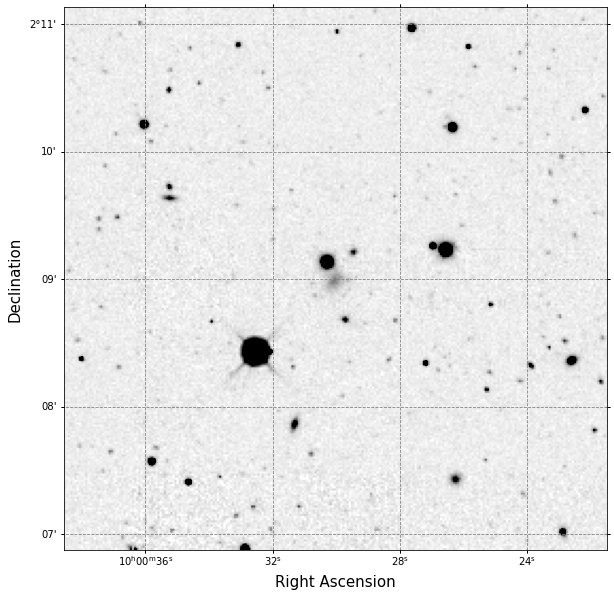

In [15]:
legacy_wcs = WCS(dat[0].header, dat)

fig = plt.figure(figsize = (10, 10))
plt.subplot(projection=legacy_wcs.slice(view = [1]))
plt.imshow(dat[0].data[1, :, :], cmap = 'gray_r', vmin = np.percentile(dat[0].data[1, :, :], 0.5), 
           vmax = np.percentile(dat[0].data[1, :, :], 99.5), origin = 'lower')
plt.grid(color='gray', ls='dashed')
plt.xlabel('Right Ascension', fontsize = 15)
plt.ylabel('Declination', fontsize = 15)

Why don't you try to plot the HST data with a grid over it below?

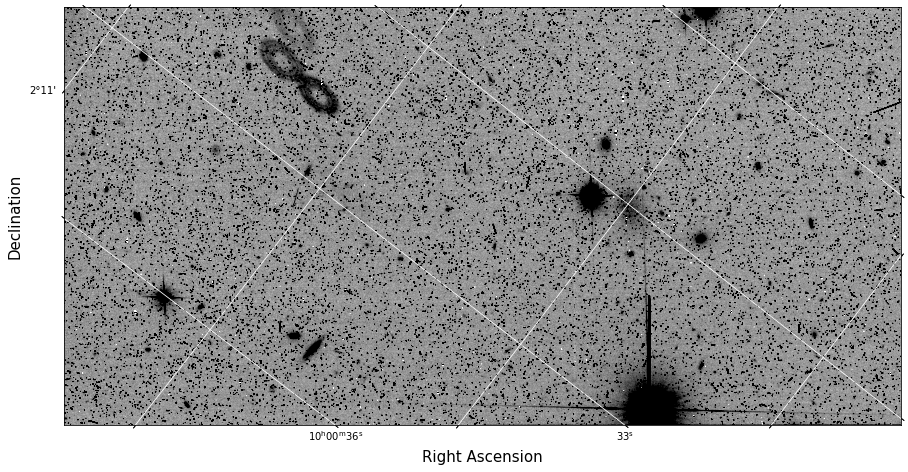

In [16]:
HST_wcs = WCS(hdulist[1].header, hdulist)

fig = plt.figure(figsize = (15, 10))
plt.subplot(projection=HST_wcs)
plt.imshow(hdulist[1].data, cmap = 'gray_r', vmin = np.percentile(hdulist[1].data, 5), 
           vmax = np.percentile(hdulist[1].data, 95), origin = 'lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension', fontsize = 15)
plt.ylabel('Declination', fontsize = 15)

We can also access information about the coordinates at a particular pixel location using _astropy.wcs.utils.pixel_to_skycoord_ (and vice versa with *.skycoord_to_pixel*). Let's identify the coordinates at the center of the HST image. We'll use the shape of the image to determine the location of the central pixel.

In [17]:
cen_coords = utils.pixel_to_skycoord(hdulist[1].data.shape[0]/2, hdulist[1].data.shape[1]/2, 
                                     wcs = HST_wcs)

cen_coords

<SkyCoord (ICRS): (ra, dec) in deg
    (150.12948238, 2.17610839)>

The result is a SkyCoord object ([documentation here](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html)), which can be manipulated to display the coordinates in different systems (like galactic coordinates) or forms (i.e., sexagesimal or degrees).

***

# Exercise

Based on the pixel scale of the initial HST image we opened (0.05 arcsec/pix) calculate the dimensions of the image in degrees. For the same image, use the header information to find the pixel location for the RA/Dec 10:00:30.03 +02:08:59.47 then show the image and mark the location of these coordinates.

In [18]:
hst_hdul = fits.open('jboa61uzq_flc.fits')
hst_wcs  = WCS(hst_hdul[1].header, hst_hdul)
hst_dat = hst_hdul[1].data

print('The HST image is %.2f deg x %.2f deg in size.'%(hst_dat.shape[0]*0.05*u.arcmin.to(u.deg), 
                                              hst_dat.shape[1]*0.05*u.arcmin.to(u.deg)))

coords = SkyCoord('10:00:30.03 +02:08:59.47', unit = [u.hourangle, u.deg])

loc = utils.skycoord_to_pixel(coords, hst_wcs)

print('10:00:30.03 + 02:08:59.47 is located at (%.2f, %.2f) in this frame.'%(loc[0], loc[1]))

The HST image is 1.71 deg x 3.41 deg in size.
10:00:30.03 + 02:08:59.47 is located at (2764.23, 1068.55) in this frame.


(-0.5, 4095.5, -0.5, 2047.5)

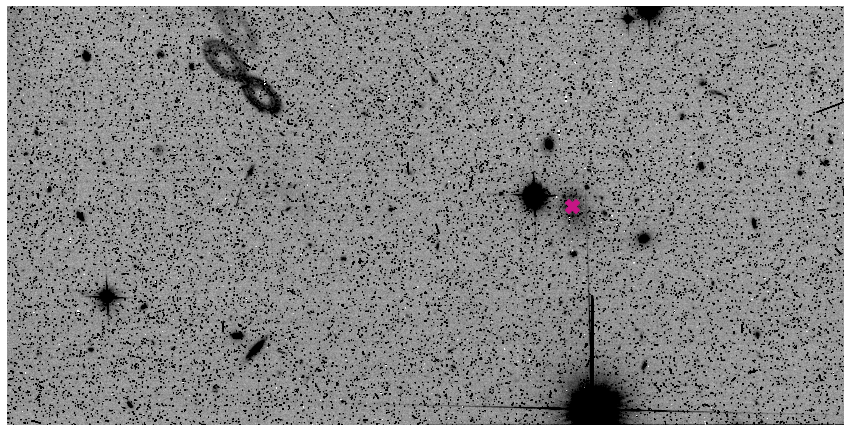

In [19]:
fig = plt.figure(figsize = (15, 10))
plt.imshow(hst_dat, cmap = 'gray_r', vmin = np.percentile(hst_dat, 5), 
           vmax = np.percentile(hst_dat, 95), origin = 'lower')
plt.scatter(loc[0], loc[1], marker = 'X', color = 'mediumvioletred', s = 200)
plt.axis('off')